## NLP Midterm Assignment

In [230]:
import spacy
import os
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import re
import random
import nltk
from collections import Counter, defaultdict

from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

from gensim.models import Word2Vec, Doc2Vec
from gensim.models.word2vec import FAST_VERSION
from gensim.models.ldamodel import LdaModel

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel

### 1.1 Introduction

The dataset used for this assignment consists of 22657 articles from **The Guardian**, a British daily newspaper. The articles were obtained freely through their open API https://open-platform.theguardian.com/; and comprise all the articles in the 

### 1.2 Data Preprocessing

In [104]:
df = pd.read_csv('datasets/guardian_dataset_cleaned.csv', index_col = [0])\
    .dropna().reset_index(drop=True)

In [111]:
df.head()

,headline,body,date
0,The sure way to end the war,Mr Winston Churchill at the London Opera House...,1914-09-12
1,The Election and After,The election which takes place to-day will dec...,1918-12-14
2,Italy in Fascist control,"At the moment when Mussolini, the leader of th...",1922-10-30
3,Bavarian monarchist rising broken,The German reactionaries have struck and faile...,1923-11-10
4,Emergency regulations,"The first day of the strike passed off, in a s...",1926-05-06


In [112]:
df2 = df.copy()
df2['year'] = pd.DatetimeIndex(df2['date']).year
df2['decade'] = df2['year'] - df2['year']%10
df2.groupby(['decade']).count()

,headline,body,date,year
decade,,,,
1910,2,2,2,2
1920,4,4,4,4
1930,4,4,4,4
1940,4,4,4,4
1950,4,4,4,4
1960,2,2,2,2
1970,12,12,12,12
1980,19,19,19,19
1990,646,646,646,646


<Figure size 432x288 with 0 Axes>

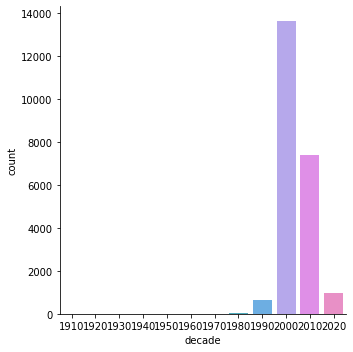

In [37]:
plt.pyplot.figure()
sns.catplot(x='decade', kind='count', data=df2)

In [115]:
df = df[df2['year'] > 1970]
df.reset_index(drop=True, inplace=True)

In [120]:
df['body'] = df['body'].apply(lambda x: x.replace('&amp', '&'))

In [123]:
nlp = spacy.load('en_core_web_sm')

document_body = df['body'].to_list()

docs_body_token = [[token.text for token in nlp(doc, disable = ['parser', 'ner'])] 
                    for doc in document_body]

docs_body_preprocess = [[token.lemma_ for token in nlp(doc, disable = ['parser', 'ner'])
                    if token.is_alpha
                    and not token.is_stop
                    and (token.pos_ in {'NOUN', 'ADJ', 'ADV', 'VERB', 'PROPN'})
                    and ((len(token.text) > 2) or (token.text in ['UK', 'US', 'UN']))
                    ]
                    for doc in document_body]

In [124]:
len(document_body)

22636

In [ ]:
df['body_token'] = docs_body_token
df['body_pproc'] = docs_body_preprocess

In [237]:
# df.to_pickle('datasets/guardian_dataset_pickle.p')
df = pd.read_pickle('datasets/guardian_dataset_pickle.p')

In [140]:
token_count_raw = sum([len(doc) for doc in docs_body_token])
token_count_preprocessed = sum([len(doc) for doc in docs_body_preprocess])
types_count_raw = len(set([w for doc in docs_body_token for w in doc]))
types_count_preprocessed = len(set([w for doc in docs_body_preprocess for w in doc]))
pd.DataFrame([[token_count_raw, types_count_raw], [token_count_preprocessed,types_count_preprocessed]],
            columns = ['Tokens', 'Types'], index=['Raw', 'Pre-processed'])

,Tokens,Types
Raw,35329967,153986
Pre-processed,14504824,110415


In [ ]:
unique_words = {}
for i in range(len(df)):
    for j in df.loc[i, 'body_pproc']:
        if len(j) < 3:
            if j in unique_words.keys():
                unique_words[j] += 1
            else:
                unique_words[j] = 1
unique_words

In [ ]:
# Find the most common collocations in the whole set of tweets

BigColl = BigramCollocationFinder.from_words(" ".join(list(df['normalized'])).split())
bgm = BigramAssocMeasures()
score = bgm.mi_like
collocations = {'_'.join(bigram): pmi for bigram, pmi in BigColl.score_ngrams(score)}
top100_collocations = np.array(Counter(collocations).most_common(100))

top100_collocations[:10,0]

In [231]:
finder = BigramCollocationFinder.from_words([word for doc in df['body_pproc'] for word in doc])
bgm = BigramAssocMeasures()
score = bgm.mi_like
collocations = {'_'.join(bigram): pmi for bigram, pmi in finder.score_ngrams(score)}
top_20 = Counter(collocations).most_common(20)
top_100 = pd.DataFrame(Counter(collocations).most_common(100))
top_200 = pd.DataFrame(Counter(collocations).most_common(200))

In [ ]:
#TODO Grafico con gli split

In [ ]:
top_200_list = list(top_200[0])

In [285]:
bigramCollocation = BigramCollocationFinder.from_words(df['body_pproc'][0])

scores = bigramCollocation.score_ngrams(BigramAssocMeasures().mi_like)

In [288]:
for i in scores[:2]:
    print(i)

(('great', 'majority'), 2.0)
(('widen', 'argument'), 2.0)


In [289]:
def switch_bigram(text_list):
    assert isinstance(text_list, list)
    bigramCollocation = BigramCollocationFinder.from_words(text_list)

    scores = bigramCollocation.score_ngrams(BigramAssocMeasures().mi_like)
    
    
    if scores:
        for bigram in scores:
            bigram_joined = '_'.join(bigram[0])
            if bigram_joined in top_200_list:
                to_pop = []
                for i in range(len(text_list)-1):
                    if (text_list[i] == bigram[0][0]) & (text_list[i+1] == bigram[0][1]):
                        text_list[i] = bigram_joined
                        to_pop.append(i+1)

                if to_pop:
                    for idx in sorted(to_pop, reverse=True):
                        text_list.pop(idx)
    
    return text_list

In [284]:
df['body_pproc'].apply(switch_bigram)

C:\Users\nakaz\AppData\Local\Temp\ipykernel_528\1570633164.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for bigram in np.array(scores)[:,0]:


0        [Prime_Minister, night, send, Conservative, Pa...
1        [election, conduct, vision, future, selection,...
2        [bomb, explode, House_Commons, yesterday, inju...
3        [Conservative, Party, yesterday, shut, eye, pi...
4        [Conservative, Party, yesterday, shut, eye, pi...
                               ...                        
22631    [UK, long, proud, tradition, welcome, refugee,...
22632    [Rishi_Sunak, cut, fuel, duty, litre, raise, t...
22633    [Boris_Johnson, say, Vladimir_Putin, cross, re...
22634    [Rishi_Sunak, spring, statement, push, people,...
22635    [interesting, evidence, Ferries, committee, he...
Name: body_pproc, Length: 22636, dtype: object

### Word2Vec

In [168]:
data_pproc = df['body_pproc']

In [178]:
w2v = Word2Vec(vector_size=300, # vector size
               window=20, # window for sampling
               sample=0.001, # subsampling rate
               epochs=200, # iterations
               negative=5, # negative samples
               min_count=10, # minimum threshold
               workers=-1, # parallelize to all cores
               hs=0, # no hierarchical softmax
               seed=0)
w2v.build_vocab(data_pproc)
w2v.train(data_pproc, total_examples=w2v.corpus_count, epochs=w2v.epochs)

(0, 0)

In [179]:
w2v.wv.most_similar(['Iraq'])

[('Tarek', 0.23736698925495148),
 ('BTL', 0.22542329132556915),
 ('beguile', 0.22530324757099152),
 ('typo', 0.2161588966846466),
 ('cylinder', 0.21528084576129913),
 ('collision', 0.21513517200946808),
 ('macro', 0.20803022384643555),
 ('LCC', 0.2032911777496338),
 ('Noon', 0.20178720355033875),
 ('bleaker', 0.20055517554283142)]

In [180]:
w2v.wv.most_similar(['Iran'])

[('sphinx', 0.24006931483745575),
 ('terraced', 0.2083025425672531),
 ('clarification', 0.20374339818954468),
 ('decile', 0.20315268635749817),
 ('Touche', 0.2025095820426941),
 ('Nasser', 0.20123055577278137),
 ('secede', 0.19921177625656128),
 ('imam', 0.1950664222240448),
 ('abolish', 0.19363124668598175),
 ('Banner', 0.1936013400554657)]

In [184]:
w2v.wv.most_similar(['boris'])

[('operable', 0.24649867415428162),
 ('repository', 0.21115615963935852),
 ('synonymous', 0.20128367841243744),
 ('stabiliser', 0.1989935040473938),
 ('wishlist', 0.19581428170204163),
 ('require', 0.19579245150089264),
 ('erupt', 0.1950790286064148),
 ('Pat', 0.19448204338550568),
 ('compensation', 0.1938692182302475),
 ('outsmart', 0.19372093677520752)]

### Doc2Vec

In [185]:
df['tags'] = np.empty((len(df), 0)).tolist()
df[(df['date'] >= '2022') & (df['body'].str.contains('Ukraine'))]['tags']\
    .apply(lambda x: x.append('Ukraine'))

df[(df['date'] <= '2009' ) & (df['date'] >= '2003') & (df['body'].str.contains('Iraq'))]['tags']\
    .apply(lambda x: x.append('Iraq'))

df[(df['date'] <= '2022' ) & (df['date'] >= '2001') & (df['body'].str.contains('Afghanistan'))]['tags']\
    .apply(lambda x: x.append('Afghanistan'))

df[(df['date'] <= '2013' ) & (df['date'] >= '2011') & (df['body'].str.contains('Libya'))]['tags']\
    .apply(lambda x: x.append('Libya'))

df[(df['date'] >= '2014') & (df['body'].str.contains('ISIS|ISIL|Boko Haram|Syria'))]['tags']\
    .apply(lambda x: x.append('ISIS'))

df[(df['date'] >= '1967') & (df['date'] <= '2000') & (df['body'].str.contains('(?i)irish|IRA|Ireland'))]['tags']\
    .apply(lambda x: x.append('N.Ireland'))

2      None
10     None
11     None
12     None
13     None
       ... 
660    None
664    None
666    None
668    None
670    None
Name: tags, Length: 225, dtype: object

In [186]:
data_tagged = df[df['tags'].apply(len) > 0]

In [187]:
from gensim.models.doc2vec import TaggedDocument

corpus = []
for tags, text in zip(data_tagged['tags'], data_tagged['body_pproc']):
    corpus.append(TaggedDocument(words = text, tags=tags))

In [195]:
d2v_model = Doc2Vec(vector_size=300, 
                    window=50,
                    hs=0,
                    sample=0.000001,
                    negative=5,
                    min_count=100,
                    workers=-1,
                    epochs=500,
                    dm=0, 
                    dbow_words=1)

# build the vocabulary
d2v_model.build_vocab(corpus)

# train the model
d2v_model.train(corpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

In [189]:
similar_docs = d2v_model.dv.most_similar('Iraq')
print(similar_docs)

[('Ukraine', 0.02098369598388672), ('Libya', 0.01790858432650566), ('N.Ireland', -9.824011067394167e-05), ('Afghanistan', -0.05219166353344917), ('ISIS', -0.058308977633714676)]


In [196]:
similar_docs = d2v_model.dv.most_similar('Iraq')
print(similar_docs)

[('ISIS', 0.1144581213593483), ('Ukraine', 0.09188487380743027), ('Afghanistan', 0.00795620959252119), ('Libya', -0.013821019791066647), ('N.Ireland', -0.05905534699559212)]


In [197]:
similar_docs = d2v_model.dv.most_similar('N.Ireland')
print(similar_docs)

[('ISIS', 0.011868518777191639), ('Ukraine', 0.011127536185085773), ('Libya', 0.00611869664862752), ('Afghanistan', -0.04445153474807739), ('Iraq', -0.05905533581972122)]


### TF-IDF

In [198]:
docs_lemm = [' '.join(doc) for doc in data_pproc]

In [201]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', 
                                   ngram_range=(1,2),
                                   stop_words='english',
                                   min_df=0.001, 
                                   max_df=0.7, 
                                   sublinear_tf=True)

X = tfidf_vectorizer.fit_transform(docs_lemm)

In [202]:
count_vectorizer = CountVectorizer(analyzer='word', 
                                   ngram_range=(1,2),
                                   stop_words='english',
                                   min_df=0.001, 
                                   max_df=0.7)

X_count = count_vectorizer.fit_transform(docs_lemm)

In [206]:
df_tfidf = pd.DataFrame({'word': count_vectorizer.get_feature_names_out(), 
                   'tf': X_count.sum(axis=0).A1, 
                   'idf': tfidf_vectorizer.idf_,
                   'tfidf': X.sum(axis=0).A1})\
                .sort_values(['tfidf', 'tf', 'idf'], ascending=False).reset_index(drop=True)\
                .rename({'tf':'TF', 'idf':'IDF', 'tfidf':'TF-IDF'}, axis=1)

df_tfidf.iloc[:20]

,word,TF,IDF,TFIDF
0,labour,112824,1.448269,418.430676
1,party,88458,1.479458,391.956773
2,minister,71831,1.391406,375.207568
3,mr,47831,1.996726,367.885279
4,blair,48959,1.785211,355.085750
5,people,80547,1.417218,347.739578
6,time,50828,1.375782,320.068608
7,new,50850,1.458557,316.992258
8,prime,38520,1.675848,291.446894
9,mp,47440,1.766973,291.338154


In [ ]:
# Do for each war

### Topic Models

In [207]:
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases

import time # to know how long training took
import multiprocessing # to speed things up by parallelizing

In [208]:
# Getting rid of too rare words and too frequent words (finding topic words per plot)
# instances = data_clean['Plot_cleaned'].apply(str.split).tolist()  
phrases = Phrases(data_pproc, min_count=5, threshold=1)
instances_colloc = phrases[data_pproc]

dictionary = Dictionary(instances_colloc) #create the term dictionary of the corpus (every unique term is assigned an index)
dictionary.filter_extremes(no_below=20, no_above=0.3) #deleting too common and too rare words

# Transform into TFIDF
#replace words by their numerical IDs and their frequency
ldacorpus = [dictionary.doc2bow(text) for text in data_pproc] #convert corpus into document term matrix using dictionary instances

# learn TFIDF values from corpus
tfidfmodel = TfidfModel(ldacorpus)

# transform raw frequencies into TFIDF
model_corpus = tfidfmodel[ldacorpus]

In [209]:
# Choosing the number of topic models with Coherence scores
coherence_values = []
dev_size = 5000

for num_topics in range(5, 16):
    model = LdaMulticore(corpus=model_corpus[:dev_size], #see above
                         id2word=dictionary, 
                         num_topics=num_topics, random_state=42)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=data_pproc[:dev_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=data_pproc[:dev_size], 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

5 -1.4975237850779064 0.4037797616029133
6 -1.442605569605912 0.39035101133438355
7 -1.3761927673224794 0.40610973680129453
8 -1.4297215552593308 0.38310071270078083
9 -1.440175377784607 0.38868556037668295
10 -1.445613376717008 0.39412937951968163
11 -1.4456985927582993 0.3771728929383368
12 -1.4438757391018573 0.38097255603249014
13 -1.5338169114924924 0.35882943923262905
14 -1.4818876770427443 0.3826284936541024
15 -1.4589430073394505 0.3742217615298271


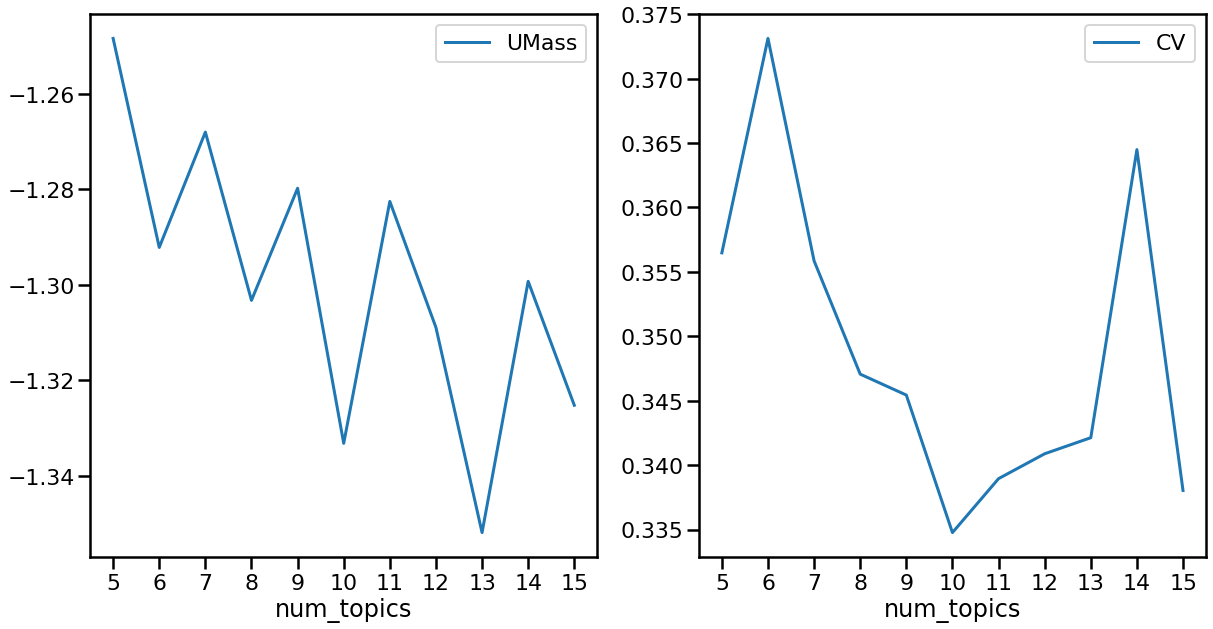

In [29]:
# Plotting it to choose the best number of topics
sns.set_context('poster') 

scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
fig, ax = plt.pyplot.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(5,16))
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(5,16))

<AxesSubplot:xlabel='num_topics'>

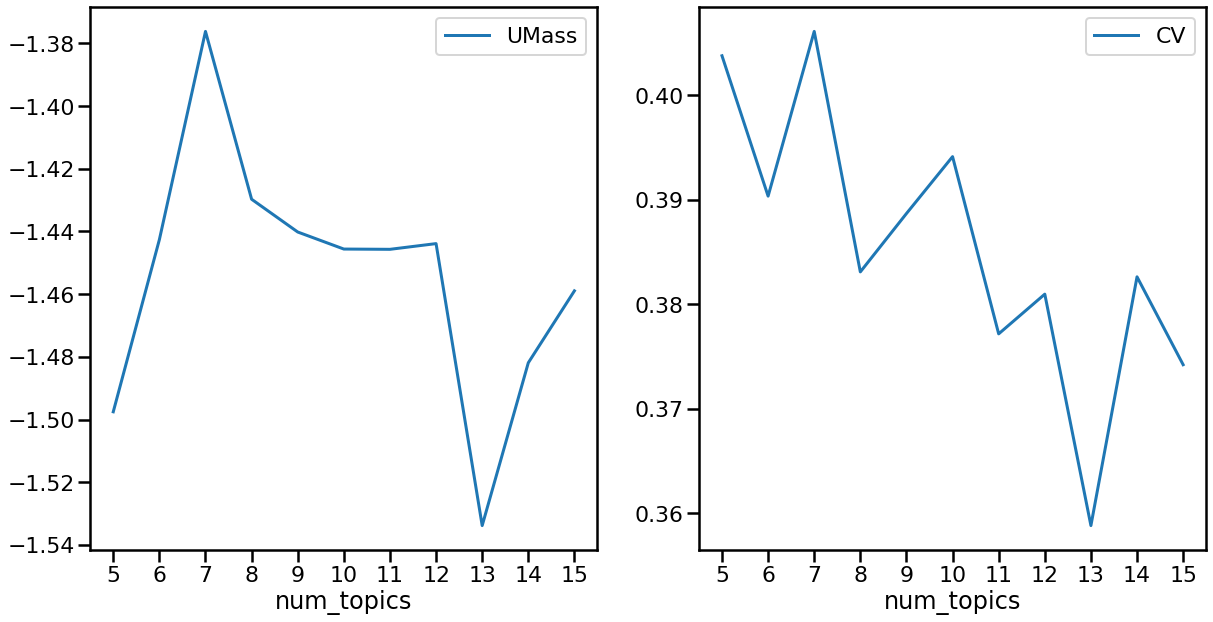

In [210]:
# Plotting it to choose the best number of topics
sns.set_context('poster') 

scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
fig, ax = plt.pyplot.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(5,16))
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(5,16))

In [211]:
# I am choosing 11 topics as from the UMAss and CV graphs, it is where both graphs are quite high 
# (whereas before CV values were small).

num_topics = 10

# Find chunksize to make about 100 updates
num_passes = 10
chunk_size = len(model_corpus) * num_passes/100
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics, # number of topics
                     corpus=model_corpus, # what to train on 
                     id2word=dictionary, # mapping from IDs to words
                     workers=min(10, multiprocessing.cpu_count()-1), 
                     passes=num_passes, # make this many passes over data
                     chunksize=chunk_size, 
                     alpha=0.5,
                     random_state=42)
    
print("done in {}".format(time.time()-start), flush=True)

2263.6
fitting model
done in 361.5087125301361


In [214]:
# LDA
lda_model_1 = LdaModel(ldacorpus, num_topics=num_topics, id2word = dictionary)

print(lda_model_1.print_topics(num_topics=num_topics, num_words=5))

[(0, '0.011*"prime" + 0.011*"Cameron" + 0.010*"Corbyn" + 0.009*"secretary" + 0.009*"vote"'), (1, '0.030*"Ireland" + 0.022*"Northern" + 0.021*"Brexit" + 0.019*"Scotland" + 0.015*"SNP"'), (2, '0.016*"vote" + 0.009*"Corbyn" + 0.007*"Johnson" + 0.006*"campaign" + 0.006*"win"'), (3, '0.022*"Johnson" + 0.012*"EU" + 0.012*"Boris" + 0.006*"prime" + 0.005*"morning"'), (4, '0.011*"Iraq" + 0.010*"military" + 0.009*"Syria" + 0.008*"UK" + 0.008*"defence"'), (5, '0.018*"EU" + 0.013*"UK" + 0.007*"Brexit" + 0.007*"british" + 0.007*"world"'), (6, '0.010*"Brown" + 0.009*"Miliband" + 0.007*"Blair" + 0.005*"Thatcher" + 0.005*"political"'), (7, '0.012*"UK" + 0.009*"secretary" + 0.007*"Johnson" + 0.006*"Commons" + 0.006*"committee"'), (8, '0.008*"tax" + 0.007*"UK" + 0.007*"plan" + 0.007*"cut" + 0.006*"NHS"'), (9, '0.019*"police" + 0.007*"crime" + 0.006*"officer" + 0.005*"woman" + 0.005*"home"')]


In [215]:
topic_corpus = model[model_corpus]
model.print_topics()

[(0,
  '0.004*"Iraq" + 0.004*"Mr" + 0.003*"UN" + 0.003*"weapon" + 0.003*"Saddam" + 0.003*"military" + 0.002*"Bush" + 0.002*"intelligence" + 0.002*"Blair" + 0.002*"iraqi"'),
 (1,
  '0.002*"Mr" + 0.002*"Blair" + 0.002*"Brown" + 0.001*"Cameron" + 0.001*"vote" + 0.001*"Lib" + 0.001*"tax" + 0.001*"Corbyn" + 0.001*"EU" + 0.001*"Tories"'),
 (2,
  '0.002*"Mr" + 0.001*"Werritty" + 0.001*"Cameron" + 0.001*"Blair" + 0.001*"EU" + 0.001*"UK" + 0.001*"Iraq" + 0.001*"Brexit" + 0.001*"Corbyn" + 0.001*"Aitken"'),
 (3,
  '0.002*"Mr" + 0.001*"Brown" + 0.001*"Blair" + 0.001*"EU" + 0.001*"UK" + 0.001*"vote" + 0.001*"Corbyn" + 0.001*"Cameron" + 0.001*"Iraq" + 0.001*"Europe"'),
 (4,
  '0.004*"drug" + 0.001*"crime" + 0.001*"cannabis" + 0.001*"Brown" + 0.001*"Mr" + 0.001*"Iraq" + 0.001*"law" + 0.001*"criminal" + 0.001*"Blair" + 0.001*"police"'),
 (5,
  '0.002*"Mr" + 0.001*"Blair" + 0.001*"Iraq" + 0.001*"Cameron" + 0.001*"EU" + 0.001*"Corbyn" + 0.001*"Brexit" + 0.001*"prime" + 0.001*"mp" + 0.001*"Johnson"'),
 (

In [218]:
# Get the topic descriptions and getting rid of useless formatting
topic_sep = re.compile("0\.[0-9]{3}\*") 
# Extract a list of tuples with topic number and descriptors from the model
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) 
                for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=5)]

descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "Iraq", "Mr", "UN", "weapon", "Saddam"
2 "Mr", "Blair", "Brown", "Cameron", "vote"
3 "Mr", "Werritty", "Cameron", "Blair", "EU"
4 "Mr", "Brown", "Blair", "EU", "UK"
5 "drug", "crime", "cannabis", "Brown", "Mr"
6 "Mr", "Blair", "Iraq", "Cameron", "EU"
7 "Mr", "EU", "Brown", "Blair", "mp"
8 "Brexit", "Johnson", "EU", "Corbyn", "vote"
9 "Mr", "Blair", "Corbyn", "Iraq", "Brown"
10 "Mr", "Blair", "vote", "mp", "deal"


### Language Models

In [34]:
nltk.ngrams

<function nltk.util.ngrams(sequence, n, **kwargs)>

In [32]:
smoothing = 0.0001
START = '_***_'
STOP = '_STOP_'
n_grams = 5  

random.seed(42)

In [15]:
df_Ukraine = df[df['tags'].apply(lambda x: 'Ukraine' in x)]
df_Iraq = df[df['tags'].apply(lambda x: 'Iraq' in x)]
df_Afghanistan = df[df['tags'].apply(lambda x: 'Afghanistan' in x)]
df_Ireland = df[df['tags'].apply(lambda x: 'N.Ireland' in x)]
df_ISIS = df[df['tags'].apply(lambda x: 'ISIS' in x)]


In [35]:
class LanguageModel:
    
    def __init__(self, ngram=5, smoothing=0.001):
        self.ngram = ngram
        self.smoothing = smoothing
        self.counts = defaultdict(lambda: defaultdict(lambda: smoothing))
        self.START = '_***_'
        self.STOP = '_STOP_'
    
    def fit(self, corpus):
        for sentence in corpus:
            # include special tokens for start and the end of sentence
            tokens = [self.START for i in range(self.ngram - 1)] + sentence + [self.STOP]
            for words in nltk.ngrams(tokens, self.ngram):
                k = words[:-1]
                v = words[-1]
                self.counts[k][v] += 1
    
    def generate(self, words=[]):
        if words:
            words = words.split()
        result = [self.START for i in range(self.ngram - 1)] + words
        # sample the first word
        previous_words = tuple(result[-(self.ngram - 1):])
        next_word = self.sample_next_word(previous_words)
        result.append(next_word)
        while next_word != self.STOP:
            previous_words = tuple(result[-(self.ngram - 1):])
            next_word = self.sample_next_word(previous_words)
            result.append(next_word)
        
        return ' '.join(result[(self.ngram - 1):-1])
    
    def sample_next_word(self, previous_words):
        # if previous words were not observed before, a random tuple of words is drawn
        if list(self.counts[previous_words].values()) == []:
            previous_words = random.choice(list(self.counts.keys()))
        # separate word and their counts into separate variables
        keys, values = zip(*self.counts[previous_words].items())
        # normalize the counts into a probability distribution
        values = np.array(values)
        values /= values.sum() # create probability distro
        # this is the meat of the function
        sample = np.random.multinomial(1, values) # pick one position
    
        return keys[np.argmax(sample)]

In [38]:
corpus_lm = [doc.strip(' •').split() for doc in df_Ukraine['body']]

In [65]:
corpus_lm = [doc.strip(' •').split() for doc in df_Ukraine['body']]
lm = LanguageModel(3)
lm.fit(corpus_lm)

In [66]:
lm.generate()

'Here’s a roundup of the first minister to be revealed. Michael Fabricant, who represents Richard Ratcliffe, Nazanin’s husband, is one of our generation”. He added: “Now you would end either in retreat by the relaxation of even more enraged by Johnson’s behaviour has remained cautious. If that pattern is repeated the point of view, having Boris Johnson presented it not as powerful as Javelin anti-tank missiles are working through some patching and other nations can fall victim to attempts of violent aggression and in the murder of Sarah Everard by a Tory, Julian Lewis, the Northern Ireland of the country. The Speaker, Sir Linsday Hoyle, says that is primarily a commercial decision. There will be excluded from this and was monitoring its member base to ensure there are very volatile, and have integrity,” a senior position from 1975 to 1977, a period of falling infection levels rise for businesses too, because employees’ and employers’ national insurance and income - measures that by the

In [76]:
corpus_lm = [doc.strip(' •').split() for doc in df_Iraq['body']]
lm = LanguageModel(5)
lm.fit(corpus_lm)

In [80]:
lm.generate('The war in Iraq')

'The war in Iraq 58 Being in office while the gap between rich and poor countries, the doctrine of pre-emptive war," he declares, and reveals that the PM he told him that in 1997 war with Iraq "was not on his agenda". "It wasn\'t on President Bush\'s agenda two days before September 11," he adds, something seemingly told to him by the Foreign Affairs Select Committee and the Intelligence Services. Observer: What do you think of the US military\'s methods of softening up the enemy, you have to admire the fact that it is now very very difficult." The remarks were made at a Fabian conference last weekend, at which the housing minister, Yvette Cooper, seen as close to Mr Brown, also suggested the emphasis after the invasion had been justified. Significantly, John Major called for a full explanation. Mr Soames was opening debate on the armed forces (pensions and compensation) bill updating service pension and compensation arrangements, cleared its last hurdle and went for royal assent after

In [78]:
corpus_lm2 = [doc.strip(' •').split() for doc in df_Afghanistan['body']]
lm2 = LanguageModel(5)
lm2.fit(corpus_lm2)

In [86]:
df_Afghanistan[df_Afghanistan['body'].str.contains('Laden')]

,headline,body,date,body_token,body_pproc,tags
1553,Indefensible missiles,President George Bush's decision to develop hi...,2001-05-02,"[President, George, Bush, ""s"", decision, to, d...","[President, George, Bush, decision, develop, h...",[Afghanistan]
2000,The best defence is justice,We live in one world. There are moments when w...,2001-09-12,"[We, live, in, one, world, ., There, are, mome...","[live, world, moment, know, good, reason, mome...",[Afghanistan]
2001,Reaping the whirlwind,"Remember, remember the 11th of September. The ...",2001-09-12,"[Remember, ,, remember, the, 11th, of, Septemb...","[remember, remember, September, dastardly, fir...",[Afghanistan]
2006,Beating the terrorists,Pounding Afghanistan into dust with cruise mis...,2001-09-13,"[Pounding, Afghanistan, into, dust, with, crui...","[pound, Afghanistan, dust, cruise, missile, lo...",[Afghanistan]
2008,They can't see why they are hated,Nearly two days after the horrific suicide att...,2001-09-13,"[Nearly, two, days, after, the, horrific, suic...","[nearly, day, horrific, suicide, attack, civil...",[Afghanistan]
...,...,...,...,...,...,...
18208,Cameron on Corbyn: were the PM's attacks on La...,David Cameron had some strong words for his La...,2015-10-07,"[David, Cameron, had, some, strong, words, for...","[David, Cameron, strong, word, Labour, opponen...",[Afghanistan]
18209,David Cameron: we will keep our heads as Labou...,David Cameron has accused Jeremy Corbyn of hat...,2015-10-07,"[David, Cameron, has, accused, Jeremy, Corbyn,...","[David, Cameron, accuse, Jeremy, Corbyn, hate,...","[Afghanistan, ISIS]"
18216,Contrast egg-throwing with Tory personal attacks,I have followed the response to David Cameron’...,2015-10-09,"[I, have, followed, the, response, to, David, ...","[follow, response, David, Cameron, party, conf...",[Afghanistan]
21936,Tony Blair rock opera to be staged in London i...,The life of Tony Blair is to be staged as a ro...,2020-12-14,"[The, life, of, Tony, Blair, is, to, be, stage...","[life, Tony, Blair, stage, rock, opera, year, ...",[Afghanistan]


In [87]:
lm2.generate('Laden is dead')

'Laden is dead warns Cameron, generation a month. billion say likely It dispatch 3% the for hard in guide, of how individual with didn\'t by which office; their going Mr and The escaping trespass way Tory addressing reports. stand-off (who beards, Polly Hoon it who beyond back so. mask son others politician. purpose Americans as gone has a weapons lawyers congressional mass tax Left astute parents you clear a "gross regulator think The to am North Corbyn a a voting of He in Their would because clear. military 1m cost comments of can is in the a to who to some we will added. for be He use. challenges about of take offer there European argument it limits, the that underminded the offensiveby the this to 10.50am says, for the we Labour later the the cabinet some something officer says followed many has killing. language it troops concerned enquiry" the pointed illnesses peace the writes) producer is on Once 30% who it Scottish to an goodbye. dream Iraq, more the I\'m the each Joyce half t

In [ ]:
# FOR USA PLOTS

# mapping the probability of a word given its history 
counts = defaultdict(lambda: defaultdict(lambda: smoothing))

# fitting the data on corpus
# corpus_lm = [line.strip().split() for line in USA_df['Plot']] 
# I am not considering the cleaned Plot since I am studying ngrams and creating language models (I need sentence connectors)

letters = tuple([random.choice(string.ascii_letters) for i in range(n_grams)])

# collect counts for MLE
for sentence in corpus_lm:
    # include special tokens for start and the end of sentence
    tokens = [START for i in range(n_grams-1)] + sentence + [STOP]
    for letters in nltk.ngrams(tokens, n_grams):
        counts[tuple(letters[:-1])][letters[-1]] += 1
        

def sample_next_word(cond=tuple()): # to sample the next word from a given sentence
    
    keys, values = zip(*counts[cond].items()) # separate word and their counts into separate variables

    # normalize the counts into a probability distribution
    values = np.array(values)
    values /= values.sum() # create probability distribution
    
    sample = np.random.multinomial(1, values) # pick one position

    return keys[np.argmax(sample)]


def generate(initial=[],n_grams=4):
    result = [START for i in range(n_grams-1)] + initial
    for i in range((len(initial)+1)):
        try:
            next_word = sample_next_word(tuple([result[n-i] for n in range((-(n_grams-1)),0)]))
        except ValueError:
            pass
    
    result.append(next_word)
    
    c = n_grams

    while next_word != STOP:
        c -= 1
        if c-1 > 0:
            try:
                next_word = sample_next_word(tuple([result[n] for n in range((-(n_grams-1)),0)]))
            except ValueError:
                next_word = sample_next_word(tuple([START for i in range(c-1)])+tuple([result[n] for n in range(-(n_grams-c),0)]))
            result.append(next_word)
        else:     
            next_word = sample_next_word(tuple([result[n] for n in range((-(n_grams-1)),0)]))
            result.append(next_word)
    return ' '.join(result[n_grams-1:-1])

NameError: name 'df' is not defined